Imports

In [ ]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import random, os


Configuration and Device Setup

In [ ]:
# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Hyperparameters
BATCH = 128
EPOCHS_MLP = 10
EPOCHS_CNN = 6
SUBSET_TRAIN_SIZE = None  # set to e.g. 10000 if compute-limited
MNIST_ROOT = "./data"


Using device: cpu


Load and Prepare Data

In [ ]:
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_ds = datasets.MNIST(MNIST_ROOT, train=True, download=True, transform=transform_mnist)
test_ds  = datasets.MNIST(MNIST_ROOT, train=False, download=True, transform=transform_mnist)
fashion_test_ds = datasets.FashionMNIST(MNIST_ROOT, train=False, download=True, transform=transform_mnist)

# Optional smaller subset
if SUBSET_TRAIN_SIZE:
    labels = np.array(train_ds.targets)
    idx = []
    per_class = SUBSET_TRAIN_SIZE // 10
    for c in range(10):
        idx_c = np.where(labels == c)[0]
        idx.extend(np.random.choice(idx_c, per_class, replace=False))
    train_ds = Subset(train_ds, idx)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH)
fashion_loader = DataLoader(fashion_test_ds, batch_size=BATCH)


100%|██████████| 9.91M/9.91M [00:00<00:00, 39.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.04MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.4MB/s]
100%|██████████| 26.4M/26.4M [00:01<00:00, 18.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 268kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.97MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.9MB/s]


Define MLP Model

In [ ]:
class MLP(nn.Module):
    def __init__(self, hidden1=30, hidden2=20):
        super().__init__()
        self.fc1 = nn.Linear(28*28, hidden1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2, 10)

    def forward(self, x, return_activations=False):
        x = x.view(x.size(0), -1)
        x = self.relu1(self.fc1(x))
        a20 = self.relu2(self.fc2(x))
        out = self.fc3(a20)
        return (out, a20) if return_activations else out


Train the MLP

In [ ]:
def train_model(model, loader, epochs, lr=1e-3):
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    for ep in range(epochs):
        model.train()
        losses = []
        for x, y in tqdm(loader, desc=f"Epoch {ep+1}/{epochs}", leave=False):
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            opt.step()
            losses.append(loss.item())
        print(f"Epoch {ep+1}: Loss = {np.mean(losses):.4f}")
    return model

mlp = MLP()
print("Training MLP...")
mlp = train_model(mlp, train_loader, EPOCHS_MLP)


Training MLP...


Epoch 1: Loss = 0.6475


Epoch 2: Loss = 0.3208


Epoch 3: Loss = 0.2783


Epoch 4: Loss = 0.2455


Epoch 5: Loss = 0.2221


Epoch 6: Loss = 0.2011


Epoch 7: Loss = 0.1854


Epoch 8: Loss = 0.1723


Epoch 9: Loss = 0.1612


Epoch 10: Loss = 0.1509


Evaluate MLP

MLP Accuracy: 0.9514, F1: 0.9509


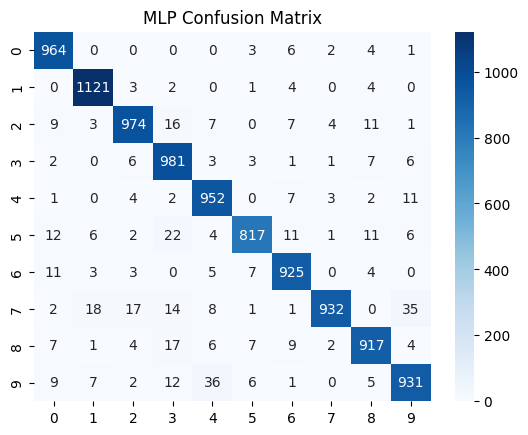

In [ ]:
def evaluate_model(model, loader):
    model.eval()
    preds, ys = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            preds.append(out.argmax(1).cpu().numpy())
            ys.append(y.numpy())
    y_pred = np.hstack(preds)
    y_true = np.hstack(ys)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    return acc, f1, cm, y_true, y_pred

acc_mlp, f1_mlp, cm_mlp, y_true_mlp, y_pred_mlp = evaluate_model(mlp, test_loader)
print(f"MLP Accuracy: {acc_mlp:.4f}, F1: {f1_mlp:.4f}")
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues')
plt.title("MLP Confusion Matrix")
plt.show()


Visualize t-SNE (Trained vs Untrained + Fashion-MNIST)

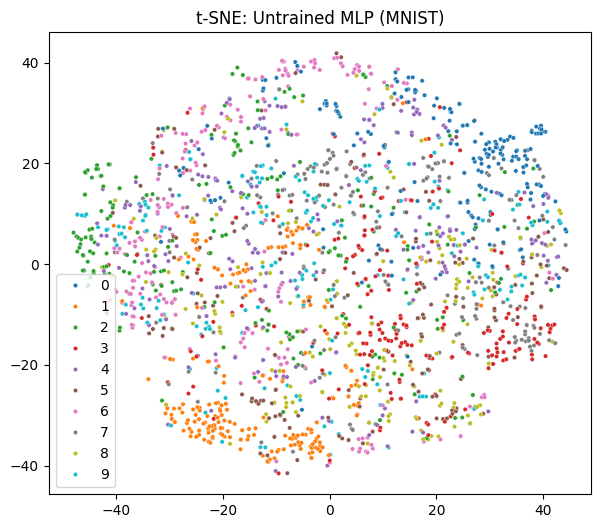

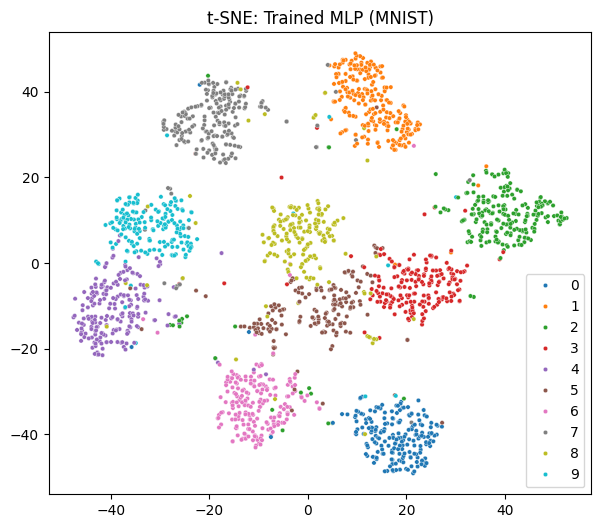

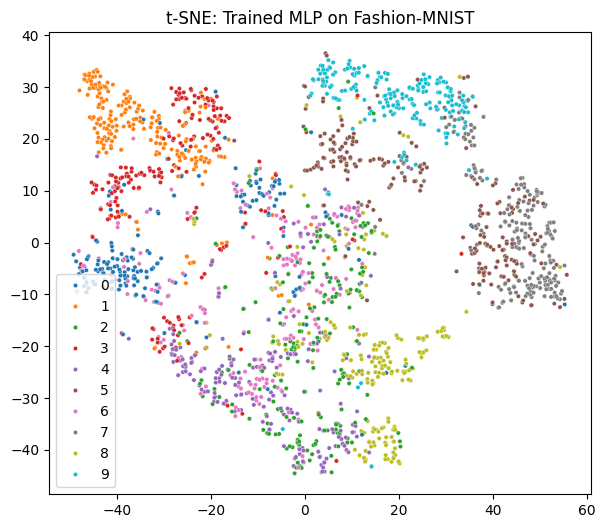

In [ ]:
def collect_acts(model, loader):
    model.eval()
    acts, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            _, a = model(x, return_activations=True)
            acts.append(a.cpu().numpy())
            labels.append(y.numpy())
    return np.vstack(acts), np.hstack(labels)

acts_trained, labels_test = collect_acts(mlp, test_loader)
acts_fashion, labels_fashion = collect_acts(mlp, fashion_loader)
acts_untrained, _ = collect_acts(MLP().to(device), test_loader)

def plot_tsne(acts, labels, title, sample_size=2000):
    if acts.shape[0] > sample_size:
        idx = np.random.choice(len(acts), sample_size, replace=False)
        acts, labels = acts[idx], labels[idx]
    ts = TSNE(n_components=2, random_state=seed, init="pca")
    z = ts.fit_transform(acts)
    plt.figure(figsize=(7,6))
    sns.scatterplot(x=z[:,0], y=z[:,1], hue=labels, palette="tab10", s=10)
    plt.title(title)
    plt.show()

plot_tsne(acts_untrained, labels_test, "t-SNE: Untrained MLP (MNIST)")
plot_tsne(acts_trained, labels_test, "t-SNE: Trained MLP (MNIST)")
plot_tsne(acts_fashion, labels_fashion, "t-SNE: Trained MLP on Fashion-MNIST")

Baseline Models (Logistic Regression & Random Forest)

In [ ]:
def get_flattened(ds):
    loader = DataLoader(ds, batch_size=1024)
    X, y = [], []
    for imgs, labels in loader:
        X.append(imgs.view(imgs.size(0), -1).numpy())
        y.append(labels.numpy())
    return np.vstack(X), np.hstack(y)

X_train, y_train = get_flattened(train_ds)
X_test, y_test = get_flattened(test_ds)

print("Training Random Forest...")
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf_clf.fit(X_train, y_train)
y_rf = rf_clf.predict(X_test)

print(f"RF Accuracy: {accuracy_score(y_test, y_rf):.4f}, F1: {f1_score(y_test, y_rf, average='macro'):.4f}")

print("Training Logistic Regression...")
lr_clf = LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1)
lr_clf.fit(X_train, y_train)
y_lr = lr_clf.predict(X_test)

print(f"LR Accuracy: {accuracy_score(y_test, y_lr):.4f}, F1: {f1_score(y_test, y_lr, average='macro'):.4f}")


Training Random Forest...
RF Accuracy: 0.9693, F1: 0.9691
Training Logistic Regression...
LR Accuracy: 0.9251, F1: 0.9241


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


CNN Model

Training CNN...


Epoch 1: Loss = 0.2526


Epoch 2: Loss = 0.0780


Epoch 3: Loss = 0.0521


Epoch 4: Loss = 0.0415


Epoch 5: Loss = 0.0314


Epoch 6: Loss = 0.0250
CNN Accuracy: 0.9852, F1: 0.9851


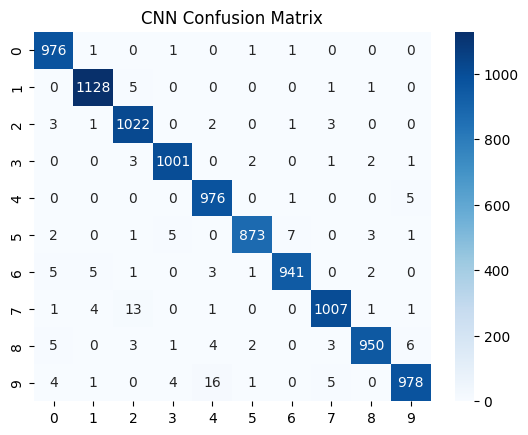

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(32*14*14, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.pool(self.relu(self.conv(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

cnn = SimpleCNN().to(device)
print("Training CNN...")
cnn = train_model(cnn, train_loader, EPOCHS_CNN)
acc_cnn, f1_cnn, cm_cnn, _, _ = evaluate_model(cnn, test_loader)
print(f"CNN Accuracy: {acc_cnn:.4f}, F1: {f1_cnn:.4f}")
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues')
plt.title("CNN Confusion Matrix")
plt.show()


Pretrained Models (AlexNet, MobileNetV2)

Device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 505kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.61MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 16.4MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weig

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 194MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 152MB/s]


Param counts (before freezing): AlexNet: 57044810 MobileNetV2: 2236682

=== Fine-tuning AlexNet head ===


Epoch 1/10: head loss = 0.7836


Epoch 2/10: head loss = 0.1140


Epoch 3/10: head loss = 0.0823


Epoch 4/10: head loss = 0.0873


Epoch 5/10: head loss = 0.0788


Epoch 6/10: head loss = 0.0760


Epoch 7/10: head loss = 0.0682


Epoch 8/10: head loss = 0.0606


Epoch 9/10: head loss = 0.0512


Epoch 10/10: head loss = 0.0466


AlexNet (head only) -> Accuracy: 0.9849, F1_macro: 0.9849

=== Fine-tuning MobileNetV2 head ===


Head-train ep 1/10:   0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/10: head loss = 0.9540


Epoch 2/10: head loss = 0.4167


Epoch 3/10: head loss = 0.3225


Epoch 4/10: head loss = 0.2781


Epoch 5/10: head loss = 0.2510


Epoch 6/10: head loss = 0.2288


Epoch 7/10: head loss = 0.2125


Epoch 8/10: head loss = 0.1985


Epoch 9/10: head loss = 0.1900


Epoch 10/10: head loss = 0.1770


MobileNetV2 (head only) -> Accuracy: 0.9436, F1_macro: 0.9430


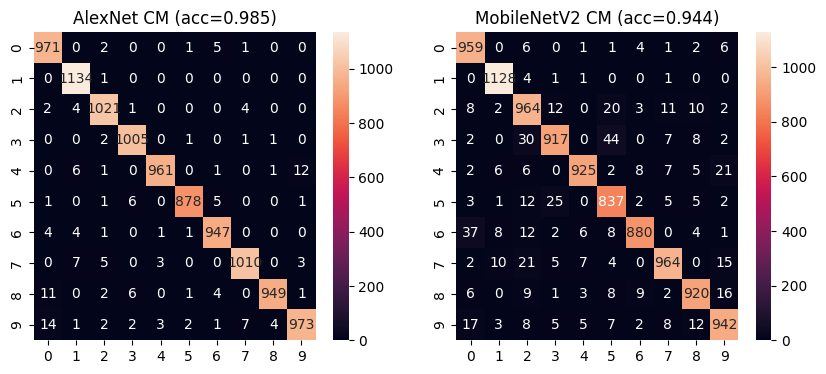

Inference time (per pass over test set):


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AlexNet time (s): 12.515962730000012
MobileNetV2 time (s): 13.519015652999997


In [1]:
# Fine-tune classifier heads for AlexNet and MobileNetV2 on MNIST (224x224 -> 3-ch)
# Run in Colab or local environment where torch + torchvision are installed.

import time, os, random
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ---------- Config ----------
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

BATCH = 128
EPOCHS_HEAD = 10
SUBSET_TRAIN_SIZE = 10000
MNIST_ROOT = './data_mnist'

os.makedirs(MNIST_ROOT, exist_ok=True)

# ---------- Transforms ----------
transform_pretrained = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),  # MNIST grayscale -> 3 channels
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ---------- Datasets & Loaders ----------
train_full = datasets.MNIST(MNIST_ROOT, train=True, download=True, transform=transform_pretrained)
test = datasets.MNIST(MNIST_ROOT, train=False, download=True, transform=transform_pretrained)

if SUBSET_TRAIN_SIZE is not None and SUBSET_TRAIN_SIZE < len(train_full):
    labels = np.array(train_full.targets)
    per_class = SUBSET_TRAIN_SIZE // 10
    indices = []
    for c in range(10):
        idxs = np.where(labels==c)[0]
        selected = np.random.choice(idxs, per_class, replace=False).tolist()
        indices.extend(selected)
    train_ds = Subset(train_full, indices)
else:
    train_ds = train_full

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test, batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True)

# ---------- Helpers ----------
def count_params(model):
    return sum(p.numel() for p in model.parameters())

def measure_time(model, loader, runs=1):
    model.eval()
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    start = time.perf_counter()
    with torch.no_grad():
        for _ in range(runs):
            for imgs, _ in loader:
                imgs = imgs.to(device)
                _ = model(imgs)
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    return (time.perf_counter() - start)/runs

def evaluate(model, loader):
    model.eval()
    ys, preds = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            preds.append(out.argmax(dim=1).cpu().numpy())
            ys.append(y.numpy())
    y_true = np.hstack(ys); y_pred = np.hstack(preds)
    return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='macro'), confusion_matrix(y_true, y_pred)

# ---------- Build models and replace heads ----------
# AlexNet
alex = models.alexnet(pretrained=True)
# Replace last classifier layer with 10-class head
in_feats_alex = alex.classifier[-1].in_features if hasattr(alex.classifier[-1], 'in_features') else 4096
alex.classifier = nn.Sequential(
    nn.Dropout(),
    nn.Linear(256 * 6 * 6, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, 10)
)
alex = alex.to(device)

# MobileNetV2
mnet = models.mobilenet_v2(pretrained=True)
mnet.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(mnet.last_channel, 10)
)
mnet = mnet.to(device)

print("Param counts (before freezing): AlexNet:", count_params(alex), "MobileNetV2:", count_params(mnet))

# ---------- Freeze base params, unfreeze heads ----------
def unfreeze_head(model):
    for p in model.parameters():
        p.requires_grad = False
    # assume model.classifier exists and contains the head
    for p in model.classifier.parameters():
        p.requires_grad = True

unfreeze_head(alex)
unfreeze_head(mnet)

# ---------- Training loop for head-only fine-tuning ----------
def train_head(model, train_loader, epochs=EPOCHS_HEAD, lr=1e-3):
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    opt = optim.Adam(params, lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    for ep in range(epochs):
        model.train()
        losses = []
        for x, y in tqdm(train_loader, desc=f"Head-train ep {ep+1}/{epochs}", leave=False):
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            opt.step()
            losses.append(loss.item())
        print(f"Epoch {ep+1}/{epochs}: head loss = {np.mean(losses):.4f}")
    return model

# ---------- Fine-tune AlexNet head ----------
print("\n=== Fine-tuning AlexNet head ===")
alex = train_head(alex, train_loader, epochs=EPOCHS_HEAD, lr=1e-3)
acc_alex, f1_alex, cm_alex = evaluate(alex, test_loader)
print(f"AlexNet (head only) -> Accuracy: {acc_alex:.4f}, F1_macro: {f1_alex:.4f}")

# ---------- Fine-tune MobileNetV2 head ----------
print("\n=== Fine-tuning MobileNetV2 head ===")
mnet = train_head(mnet, train_loader, epochs=EPOCHS_HEAD, lr=1e-3)
acc_mnet, f1_mnet, cm_mnet = evaluate(mnet, test_loader)
print(f"MobileNetV2 (head only) -> Accuracy: {acc_mnet:.4f}, F1_macro: {f1_mnet:.4f}")

# ---------- Confusion matrices and timings ----------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); sns.heatmap(cm_alex, annot=True, fmt='d'); plt.title(f'AlexNet CM (acc={acc_alex:.3f})')
plt.subplot(1,2,2); sns.heatmap(cm_mnet, annot=True, fmt='d'); plt.title(f'MobileNetV2 CM (acc={acc_mnet:.3f})')
plt.show()

print("Inference time (per pass over test set):")
print("AlexNet time (s):", measure_time(alex, test_loader, runs=1))
print("MobileNetV2 time (s):", measure_time(mnet, test_loader, runs=1))
